# Intuit Quickbooks Upgrade

* Team-lead GitLab userid:
* Group name:
* Team member names:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import xgboost as xgb
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import random


# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
#intuit75k.head()

In [3]:
# run python code from another notebook
#%run ./sub-notebooks/model1.ipynb

In [4]:
# importing functions from a module/package
from utils import functions
#functions.example()

In [5]:
print(f'Decision Tree Model Pre-processing\n')

Decision Tree Model Pre-processing



In [6]:
print(f'To load variables into the decision tree model, the zip_bins variable from the initial data will be converted to a set of dummy variables with the zip-codes for 00801 and 00804. Since there are 3 possibilities for the sex variable, they will be converted to dummy variables as well. The rest of the models will be used as they are.\n')

To load variables into the decision tree model, the zip_bins variable from the initial data will be converted to a set of dummy variables with the zip-codes for 00801 and 00804. Since there are 3 possibilities for the sex variable, they will be converted to dummy variables as well. The rest of the models will be used as they are.



In [7]:
break_even = 1.41 / 60

In [8]:
# converting types of variables and creation of necessary dummy variables
intuit75k = intuit75k.assign(zip801 = (intuit75k['zip'] == '00801').astype(int),
                            zip804 = (intuit75k['zip'] == '00804').astype(int),)

In [9]:
rvar = "res1_yes"
var = [
    "zip_bins",
    "sex",
    "bizflag",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
]
std_evars = ["numords",
    "dollars",
    "last",
    "sincepurch",
]

avar = [
    "zip_bins",
    "sex",
    "bizflag",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
    "numords",
    "dollars",
    "last",
    "sincepurch",
]
evar = [
    "zip_bins",
    "bizflag",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
    "numords",
    "dollars",
    "last",
    "sincepurch",
    "Female",
    "Male",
    "Unknown",
]

idvar = "id"
lev = 1

In [10]:
train = intuit75k.loc[intuit75k['training'] == 1]
test = intuit75k.loc[intuit75k['training'] == 0]

In [11]:
eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]

In [12]:
X_train = train[avar]
y_train = train[rvar]
X_test = test[avar]
y_test = test[rvar]

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
X_train[["Female","Male","Unknown"]] = pd.get_dummies(X_train["sex"], drop_first = False)
X_train = X_train.drop(["sex"], axis = 1)
X_test[["Female","Male","Unknown"]] = pd.get_dummies(X_test["sex"], drop_first = False)
X_test = X_test.drop(["sex"], axis = 1)

In [15]:
X = np.concatenate((X_train, X_test), axis=0)

In [16]:
print(f'Decision Tree Model\n')

Decision Tree Model



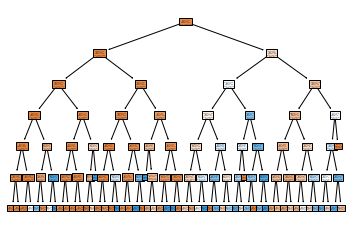

In [17]:
#Large Tree
clf = tree.DecisionTreeClassifier(max_depth = 6, random_state = 1234).fit(X_train, y_train)
fig = tree.plot_tree(clf, feature_names=evar, class_names=["yes", "no"], filled=True)

In [18]:
tree_proba = clf.predict_proba(X)
eval_dat["y_tree"] = tree_proba[:, 1]
eval_dat["y_tree"] = eval_dat["y_tree"]/2

In [19]:
#eval_dat["mailto"] = eval_dat["y_tree"] > break_even
#eval_dat["mailto"].value_counts()

In [20]:
print(f'\n\nAfter predicting using this model, the AUC score for the training and testing models are indicated below. After running a cross validation for this model, the only noticeable difference was in the `max_depth` hyper parameter. Since the suggested number was 6, the model above was tuned with 6 as the depth and the results are shown below.\n') 



After predicting using this model, the AUC score for the training and testing models are indicated below. After running a cross validation for this model, the only noticeable difference was in the `max_depth` hyper parameter. Since the suggested number was 6, the model above was tuned with 6 as the depth and the results are shown below.



In [21]:
# prediction on training & testing sets
pred_cv_tr = clf.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_cv_tr[:, 1])

pred_t = clf.predict_proba(X_test)
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, pred_t[:, 1])

print(f"AUC training data for tuned optimal model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for tuned optimal model: {metrics.auc(fpr_t, tpr_t)}\n")

AUC training data for tuned optimal model: 0.7658371647520008
AUC testing data for tuned optimal model: 0.7467773356522853



In [22]:
# CV for trees
param_grid = {"max_depth": list(range(2, 10)), "random_state":[1234]}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X_train, y_train)
print(f'\n')

Fitting 5 folds for each of 8 candidates, totalling 40 fits




In [23]:
clf_cv.best_params_

{'max_depth': 6, 'random_state': 1234}

In [24]:
clf_cv.best_score_

0.7490798028609724

In [25]:
# function for the lifts and gains plot
def plot(resp):
    # lift and gains plot
    w = 13
    h = 4
    d = 100
    fig = plt.figure(figsize=(w, h), dpi=d)
    fig.suptitle(f"Cumulative Lift and Gains For DCT Model")

    fig1 = fig.add_subplot(122)
    fig1.set_title("Cumulative Gains")
    fig1 = rsm.gains_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

    fig2 = fig.add_subplot(121)
    fig2.set_title("Cumulative Lift")
    fig2 = rsm.lift_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

In [26]:
print(f'The plots below show the cumulative lifts and gains for this model, which show slight indications of overfitting, but are noticeable after the proportion of customers passes 0.3.\n')

The plots below show the cumulative lifts and gains for this model, which show slight indications of overfitting, but are noticeable after the proportion of customers passes 0.3.



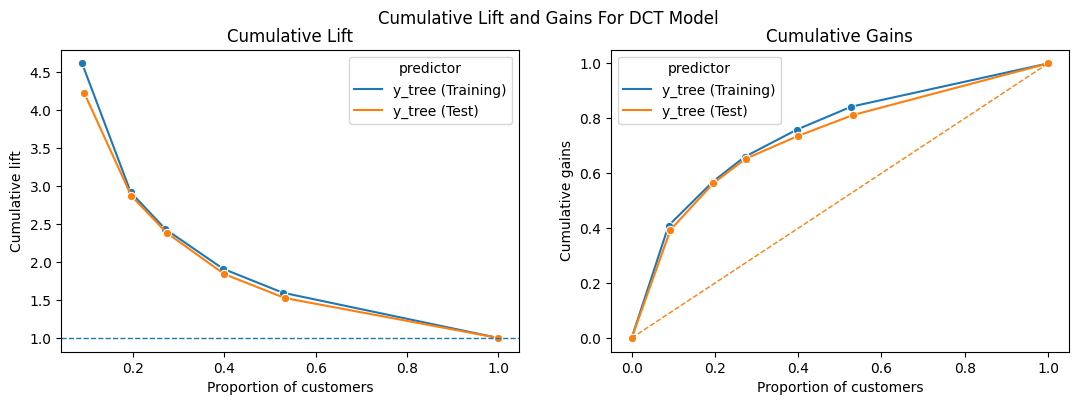

In [27]:
plot('y_tree')

In [28]:
def w2_profit(resp):
    # calculating the profit for wave-2 on test set
    breakeven = 1.41 / 60
    wave2_target = 763334
    eval_dat['mod_resp'] = eval_dat[resp] * 0.5
    eval_dat['mod_mail'] = eval_dat['mod_resp'] > breakeven
    df = eval_dat[eval_dat['training']==0]
    
    mail_true= sum(df['mod_mail']) #num of yes in test set
    mail_true_rate = mail_true / df.shape[0] #proportion to yes is test set
    buy_true = df[(df['mod_mail']==True) & (df['res1_yes']==1)] #true positives
    
    mail_number = wave2_target * mail_true_rate #customers to mail
    adjusted_rr = (buy_true.shape[0] * 0.5) / mail_true #adjusted buy rate
    wave2_buyers = adjusted_rr * mail_number #buyers in wave 2
   
    mail_cost = 1.41 * mail_number 
    profit = 60 * wave2_buyers - mail_cost
    rome = profit / mail_cost
    
    return profit,rome

In [29]:
scaled_prof, scaled_rome = w2_profit("y_tree")

print(
    f"""Wave-2 Scaled Campaign with the decision tree model: The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n"""
)

Wave-2 Scaled Campaign with the decision tree model: The Profit is $319,883 and the the return on investment is 409.75% 



In [30]:
eval_dat.to_csv("./data/DTree.csv", index=False)